# Fractional differentiate

This notebook will cover exercise answer.

* Exercise 5.6

As we go along, there will be some explanations.

Stationarity is a key concept in time-series, by now the idea itself has been demostrated in previous notebooks (Feat Importance).

Most of the functions below can be found under research/Features and /Ensemble

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import research as rs

%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

p = print

#pls take note of version
#numba 0.49.1 #https://github.com/numba/numba/issues/4255
#numpy 1.17.3
#pandas 1.0.3
#sklearn 0.21.3

dollar = pd.read_csv('./research/Sample_data/dollar_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])

# For most part of the func we only use 'close'

close = dollar['close'].to_frame()

Num of CPU core:  4
Machine info:  Windows-10-10.0.18362-SP0
Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy 1.17.3
Pandas 1.0.3


C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1500x800 with 1 Axes>

In [2]:
ffd_series = close.apply(np.log).cumsum()
ffd_series = rs.fracDiff_FFD(ffd_series, 
                    d = 1.99999889, 
                    thres=1e-5
                   ).dropna()

adf_pval = adfuller(ffd_series.squeeze(), 
                    maxlag = 1,
                    regression='c', 
                    autolag=None)[1]

p("\nADF pVal: {0:.5f} with critical value: {1}%".format(adf_pval, 5)) #confirm stationarity


ADF pVal: 0.04165 with critical value: 5%


In [3]:
ffd_series.head()

,close
date_time,
2015-01-02 09:35:57.204,-0.001693
2015-01-02 12:59:42.176,0.000243
2015-01-02 14:19:33.847,0.001329
2015-01-02 14:33:39.311,0.000355
2015-01-02 14:42:28.315,0.000714


In [4]:
ffd_series.tail()

,close
date_time,
2016-12-30 20:59:58.848,-0.101709
2016-12-30 21:00:00.352,-0.102272
2016-12-30 21:00:24.294,-0.101718
2016-12-30 21:03:03.027,-0.102393
2016-12-30 21:13:31.990,-0.102062


In [5]:
cs_event = rs.cs_filter(data = ffd_series, limit=(ffd_series.std() * 0.2))

p(len(cs_event))

839


**Note**

This is the real reason why cs_filter was created, it was meant to be applied to stationary series.

Our stationary series can act as our anchor for our mean-reversion strategy, that is why we are using cs_filter on this series to sample feature matrix.

However, due to the lack of data sample/ resource, I cannot use 2 x std. (In fact, we would have been able to increase our F1 score in previous chapters, if we had enough data samples.)

Based on my previous trials, when 1 x std is applied, the series itself will reduce heteroscedasticity even if it was not stationary.

If you have the means to sample 5 - 10 years data, feel free to change to 2 x std.

In [6]:
#This portion requires combining events based on ffd_series with original dollar close using filtered index
# since filter is based on ffd, therefore index matrix must also be based on filtered ffd
df_mtx = pd.DataFrame(index = cs_event).assign(close = close,
                                                ffd_series = ffd_series).drop_duplicates().dropna()
df_mtx

,close,ffd_series
2015-01-04 23:20:12.567,2040.75,-0.003825
2015-01-07 10:55:23.194,2008.00,0.004166
2015-01-07 15:10:50.900,2014.50,-0.002360
2015-01-08 01:48:57.964,2037.25,0.006857
2015-01-08 05:47:32.006,2032.75,-0.003119
...,...,...
2016-11-28 01:31:48.252,2205.75,-0.099969
2016-12-04 23:32:49.403,2183.50,-0.102717
2016-12-05 02:06:52.025,2189.00,-0.096321
2016-12-08 12:46:05.346,2233.00,-0.101778


In [7]:
df_mtx['volatility'] = rs.vol(df_mtx.close, span0 = 50) #one of our features, since we do not have a side

df_mtx.dropna(inplace = True)

In [8]:
vb = rs.vert_barrier(data = df_mtx.close, events = cs_event, period = 'days', freq = 5)

In [9]:
# triple barrier events based on filter while data is also based on filtered index
tb = rs.tri_barrier(data = df_mtx.close, 
                    events = cs_event, 
                    trgt = df_mtx['volatility'], 
                    min_req = 0.0002, 
                    num_threads = 3, 
                    ptSl= [2,2], #2x barriers
                    t1 = vb, 
                    side = None)
    


C:\Users\Wei_X\Desktop\Python\research\Labels\triple_barrier_method.py:75: UserWarning: Data and events index shape must be same, reindex data to fit events
  warnings.warn('Data and events index shape must be same, reindex data to fit events')
C:\Users\Wei_X\Desktop\Python\research\Labels\triple_barrier_method.py:112: UserWarning: Not Recommended: No side prediction provided
  warnings.warn('Not Recommended: No side prediction provided')


[                                             t1                      sl  \
2015-01-07 15:10:50.900 2015-01-12 16:02:08.112                     NaT   
2015-01-08 01:48:57.964 2015-01-13 09:38:58.103                     NaT   
2015-01-08 05:47:32.006 2015-01-13 09:38:58.103                     NaT   
2015-01-09 14:48:46.704 2015-01-14 19:14:20.771 2015-01-14 04:31:40.468   
2015-01-12 14:36:34.243 2015-01-19 09:36:49.301 2015-01-14 19:14:20.771   
...                                         ...                     ...   
2015-09-01 19:46:17.742 2015-09-07 01:34:00.944                     NaT   
2015-09-01 22:05:09.069 2015-09-07 01:34:00.944                     NaT   
2015-09-02 00:20:04.277 2015-09-07 01:34:00.944                     NaT   
2015-09-02 02:09:17.333 2015-09-07 04:40:25.376                     NaT   
2015-09-02 08:08:50.931 2015-09-08 01:27:51.915                     NaT   

                                             pt  
2015-01-07 15:10:50.900 2015-01-08 01:48:57.964 

2020-05-29 16:48:39.968388 100.0% _pt_sl_t1 done after 0.12 minutes. Remaining 0.0 minutes.


In [10]:
tb

,t1,trgt
2015-01-07 15:10:50.900,2015-01-08 01:48:57.964,0.002252
2015-01-08 01:48:57.964,2015-01-13 09:38:58.103,0.007576
2015-01-08 05:47:32.006,2015-01-13 09:38:58.103,0.006867
2015-01-09 14:48:46.704,2015-01-14 04:31:40.468,0.009708
2015-01-12 14:36:34.243,2015-01-14 19:14:20.771,0.008815
...,...,...
2016-11-14 02:12:45.857,2016-11-28 01:31:48.252,0.022494
2016-11-28 01:31:48.252,2016-12-04 23:32:49.403,0.022526
2016-12-04 23:32:49.403,2016-12-14 20:09:50.768,0.022102
2016-12-05 02:06:52.025,2016-12-14 20:09:50.768,0.021669


In [11]:
mlabel = rs.meta_label(data = df_mtx.close, 
                       events = tb, 
                       drop = 0.05) # because we do not have side, we need to drop rare labels

In [12]:
mlabel['bin'].value_counts() #834

 1.0    489
-1.0    345
Name: bin, dtype: int64

In [13]:
troo = rs.mp_idx_matrix(data = df_mtx.close, events = tb)
#np.arange(troo.shape[1])
troo

,0,1,2,3,4,5,6,7,8,9,...,826,827,828,829,830,831,832,833,834,835
2015-01-07 15:10:50.900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-08 01:48:57.964,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-08 05:47:32.006,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-09 14:48:46.704,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-12 14:36:34.243,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-28 01:31:48.252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2016-12-04 23:32:49.403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2016-12-05 02:06:52.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2016-12-08 12:46:05.346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


**Quick Reference Guide/ Summary to func usage**

1. Apply cs_filter using stationary series (FFD)

2. Apply bband_as_side using close price series

3. Create a new dataframe, using both outputs with index = cs_filter output.

4. Apply func tri_barrier, Vert_barrier using new dataframe, before applying meta_label func.

5. Feed these meta lables and features to random forest.

Always include indicators, stationary series, volatility as part of your feature matrix if possible, since these are the features on how you derive meta-labels. 

As seen in previous exercises, ML models are smart enough to know what was the key parameters which meta-labels was labelled.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X = df_mtx.reindex(mlabel.index)
Z = tb.reindex(mlabel.index)
y = mlabel['bin']

X['wr'] = rs.wght_by_rtn(data = X, events = Z, num_threads = 1)
X['wt'] = rs.wght_by_td(data = X, events = Z, num_threads = 1, td = 0.5)

X #show example

C:\Users\Wei_X\Desktop\Python\research\Sampling\sample_unique.py:491: RuntimeWarning: invalid value encountered in log
  rtn = np.log(data).diff().fillna(0) # Log-returns, so that they are additive


,close,ffd_series,volatility,wr,wt
2015-01-07 15:10:50.900,2014.50,-0.002360,0.002252,3.004931,0.503742
2015-01-08 01:48:57.964,2037.25,0.006857,0.007576,2.548574,0.505364
2015-01-08 05:47:32.006,2032.75,-0.003119,0.006867,0.456357,0.506811
2015-01-09 14:48:46.704,2049.75,-0.003951,0.009708,0.651985,0.507852
2015-01-12 14:36:34.243,2030.50,-0.004798,0.008815,2.571428,0.508686
...,...,...,...,...,...
2016-11-14 02:12:45.857,2167.75,-0.097722,0.022494,1.194957,0.992436
2016-11-28 01:31:48.252,2205.75,-0.099969,0.022526,1.384323,0.994040
2016-12-04 23:32:49.403,2183.50,-0.102717,0.022102,1.510426,0.996258
2016-12-05 02:06:52.025,2189.00,-0.096321,0.021669,4.223331,0.998337


In [15]:
# Split data into train and test sets, earlier on we combine sample weights with X because we need to match during fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=None)

wght_td = X_train['wt']
wght_rtn = X_train['wr']

#weights are not feature so have to remove
X_train = X_train.drop(['wr','wt'], axis = 1)
X_test = X_test.drop(['wr','wt'], axis = 1)

wght_rtn

2015-08-26 10:34:40.144    0.394145
2015-08-25 11:37:16.214    0.488536
2016-01-08 10:53:07.196    0.817534
2015-09-23 13:11:44.559    0.736790
2015-07-01 10:25:32.469    0.581751
                             ...   
2015-03-23 08:14:01.389    1.331041
2015-05-29 10:32:41.319    0.509290
2015-09-01 13:48:58.967    0.310314
2015-12-22 09:01:07.048    0.770506
2015-05-12 14:41:49.319    2.245505
Name: wr, Length: 583, dtype: float64

In [16]:
base_estimator = DecisionTreeClassifier()

# common parameters to use, this ensemble method mimics monte-carlos as it randomly selects samples to form "forest"
n_estimate = 10
random_state = 42
max_samples = 35

In [17]:
#warning, this is a heavy algo, will take up to 15 mins to complete with current parameter

rtn_bag_cls=rs.BaggingClassifier(data = df_mtx.close,
                                events = tb,
                                base_estimator = base_estimator,
                                n_estimators = n_estimate, # the number of trees as a estimate
                                max_samples = max_samples, #if you put max_sample = 1.0, pls mentally get ready to wait
                                max_features = 1.0,
                                bootstrap = True, #must always be True
                                bootstrap_features=False,
                                oob_score = True, # You will need to have bootstrap = True
                                warm_start = False,
                                n_jobs = 1, # depending your machine. might become slower if you use all processors
                                random_state = random_state, #seed figure
                                verbose = 0)



# Fit with absolute return weights
rtn_bag_cls.fit(X_train, y_train, sample_weight = wght_rtn)

Ave uniqueness for grp sample 1: 0.647674
Ave uniqueness for grp sample 2: 0.854561
Ave uniqueness for grp sample 3: 0.849644
Ave uniqueness for grp sample 4: 0.856805
Ave uniqueness for grp sample 5: 0.867614
Ave uniqueness for grp sample 6: 0.857027
Ave uniqueness for grp sample 7: 0.804856
Ave uniqueness for grp sample 8: 0.812000
Ave uniqueness for grp sample 9: 0.904695
Ave uniqueness for grp sample 10: 0.800973


BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  data=2015-01-07 15:10:50.900    2014.50
2015-01-08 01:48:57.964    2037.25
2015-01-08 05:47:32.006    2032.75
2015-01-09 14:48:46.704    2049.75
2015-01-12 14:36:34.243    2030.50
                            ...   
2016-11-28 01:31:48.252    2205.75
2016-12-04 23:32:49.403    2183.50
2016-12-05 02:06:52.025    2189.00
2016-12-08 12:46:05.346    2233.00
2016-12-14 20:09:50.768    2...
2015-01-12 14:36:34.243 2015-01-14 19:14:20.771  0.008815
...                                         ...       ...
2016-11-14 02:12:45.857 2016-11-28 01:31:48.252  0.022494
2016-11-28 01:31:48.252 2016-12-04 23:32:49.403  0.022526
2016-12-04 23:32:49.403 2016-12-14 20:09:50.768  0.022102
2016-12-05 02:06:52.025 2016-12-14 20:09:50.768  0.021669
2016-12-08 12:46:05.346 2016-12-14 20:09:50.768  0.021819

[836 rows x 2 columns],
                  max_samples=35, n_jobs=1, oob_score=True, random_state=42)

In [18]:
p("Out-of-bag Score: {0:.6f}".format(rtn_bag_cls.oob_score_))

Out-of-bag Score: 0.668954


 Classification Report
              precision    recall  f1-score   support

        -1.0       0.58      0.70      0.63       102
         1.0       0.76      0.66      0.71       149

    accuracy                           0.67       251
   macro avg       0.67      0.68      0.67       251
weighted avg       0.69      0.67      0.68       251


 Confusion Matrix
[[TN, FP]
 [FN, TP]]

[[71 31]
 [51 98]]

 Accuracy Score
0.6733067729083665



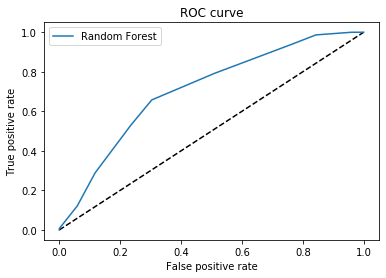

In [19]:
y_pred = rtn_bag_cls.predict(X_test)
y_prob = rtn_bag_cls.predict_proba(X_test)[:,1] #we only want true positive probability

rs.report_matrix(y_test, y_pred, y_prob)

In [20]:
td_bag_cls=rs.BaggingClassifier(data = df_mtx.close,
                                events = tb,
                                base_estimator = base_estimator,
                                n_estimators = n_estimate, # the number of trees as a estimate
                                max_samples = max_samples, #if you put max_sample = 1.0, pls mentally get ready to wait
                                max_features = 1.0,
                                bootstrap = True, #must always be True
                                bootstrap_features=False,
                                oob_score = True, # You will need to have bootstrap = True
                                warm_start = False,
                                n_jobs = 1, # depending your machine. might become slower if you use all processors
                                random_state = random_state, #seed figure
                                verbose = 0)



# Fit sample weight by time-decay
td_bag_cls.fit(X_train, y_train, sample_weight = wght_td)

Ave uniqueness for grp sample 1: 0.647674
Ave uniqueness for grp sample 2: 0.854561
Ave uniqueness for grp sample 3: 0.849644
Ave uniqueness for grp sample 4: 0.856805
Ave uniqueness for grp sample 5: 0.867614
Ave uniqueness for grp sample 6: 0.857027
Ave uniqueness for grp sample 7: 0.804856
Ave uniqueness for grp sample 8: 0.812000
Ave uniqueness for grp sample 9: 0.904695
Ave uniqueness for grp sample 10: 0.800973


BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  data=2015-01-07 15:10:50.900    2014.50
2015-01-08 01:48:57.964    2037.25
2015-01-08 05:47:32.006    2032.75
2015-01-09 14:48:46.704    2049.75
2015-01-12 14:36:34.243    2030.50
                            ...   
2016-11-28 01:31:48.252    2205.75
2016-12-04 23:32:49.403    2183.50
2016-12-05 02:06:52.025    2189.00
2016-12-08 12:46:05.346    2233.00
2016-12-14 20:09:50.768    2...
2015-01-12 14:36:34.243 2015-01-14 19:14:20.771  0.008815
...                                         ...       ...
2016-11-14 02:12:45.857 2016-11-28 01:31:48.252  0.022494
2016-11-28 01:31:48.252 2016-12-04 23:32:49.403  0.022526
2016-12-04 23:32:49.403 2016-12-14 20:09:50.768  0.022102
2016-12-05 02:06:52.025 2016-12-14 20:09:50.768  0.021669
2016-12-08 12:46:05.346 2016-12-14 20:09:50.768  0.021819

[836 rows x 2 columns],
                  max_samples=35, n_jobs=1, oob_score=True, random_state=42)

In [21]:
p("Out-of-bag Score: {0:.6f}".format(td_bag_cls.oob_score_))

Out-of-bag Score: 0.662093


 Classification Report
              precision    recall  f1-score   support

        -1.0       0.57      0.61      0.59       102
         1.0       0.72      0.68      0.70       149

    accuracy                           0.65       251
   macro avg       0.64      0.65      0.64       251
weighted avg       0.66      0.65      0.65       251


 Confusion Matrix
[[TN, FP]
 [FN, TP]]

[[ 62  40]
 [ 47 102]]

 Accuracy Score
0.6533864541832669



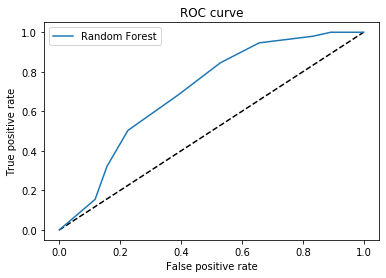

In [22]:
y_pred1 = td_bag_cls.predict(X_test)
y_prob1 = td_bag_cls.predict_proba(X_test)[:,1] #we only want true positive probability

rs.report_matrix(y_test, y_pred1, y_prob1)

### Out-of-Bag score

Original sklearn bagging method: Out-of-bag Score: 0.662093

Sequential bootstrap bagging method:
        
1. without sample weight: Out-of-bag Score: 0.655232
2. with abs return wght: Out-of-bag Score: 0.668954
3. with time-decay wght: Out-of-bag Score: 0.662093

Comparing the original sklearn bagging ensemble using decision tree classifier, our OOB score is lower.

Once we included sample weights by either absolute returns or time-decay, our OOB score becomes higher or the equal with original sklearn OOB score.

In fact, overall accuracy and f1-scores also increased with a better ROC graph. All of it with a less bias result.

**Conclusion**

Whenever we use bagging, we should try and include sample weights so that ML classification will improve the overall results.

**Note**

If you are wondering why I can get identical average uniqueness for all sample grps, just make sure you set random state.